In [1]:
import numpy as np
from typing import Tuple
from scipy.integrate import quad
from scipy.special import erfc
from util import *
from data_model import *
from scipy.optimize import root_scalar


Test on whether the moreau envelope value changes if you add an arbitrary epsilon vs if you don't


In [12]:
"""
Proximal from root scalar logistic
"""
def optim(z,y,V,w_prime):
    a = y*z
    if a <= 0:
        return y*V/(1+ np.exp(y*z)) + w_prime - z
    else:
        return y*V*np.exp(-y*z)/(1+ np.exp(-y*z)) + w_prime - z

def proximal_logistic_root_scalar(V: float, y: float, Delta: float, epsilon: float, w:float) -> float:
    if y == 0:
        return w
    try:
        w_prime = w - epsilon * Delta / y
        result = root_scalar(lambda z: optim(z,y,V,w_prime) , bracket=[-50000000,50000000],xtol=10e-10,rtol=10e-10)
        z = result.root
        return z + epsilon * Delta / y
    except Exception as e:
        # print all parameters
        print("V: ", V, "y: ", y, "Delta: ", Delta, "epsilon: ", epsilon, "w: ", w)
        raise e

def log1pexp(x):
    """Compute log(1+exp(x)) componentwise."""
    # inspired from sklearn and https://cran.r-project.org/web/packages/Rmpfr/vignettes/log1mexp-note.pdf
    # and http://fa.bianp.net/blog/2019/evaluate_logistic/
    out = np.zeros_like(x)
    idx0 = x <= -37
    out[idx0] = np.exp(x[idx0])
    idx1 = (x > -37) & (x <= -2)
    out[idx1] = np.log1p(np.exp(x[idx1]))
    idx2 = (x > -2) & (x <= 18)
    out[idx2] = np.log(1. + np.exp(x[idx2]))
    idx3 = (x > 18) & (x <= 33.3)
    out[idx3] = np.exp(-x[idx3]) + x[idx3]
    idx4 = x > 33.3
    out[idx4] = x[idx4]
    return out

def loss(y,z,epsilon,Delta):
    return log1pexp(-y*z+epsilon*Delta)

def moreau_envelope(V,y,z,Delta,epsilon,w):
    return loss(y,z,epsilon,Delta)  + ((z-w)**2)/(2*V)



In [13]:

V = 1
Delta = 1
y = 1
w = 1
for eps in np.linspace(0,1000,10):
    z = proximal_logistic_root_scalar(V,y,Delta,eps,w)
    print(z, moreau_envelope(V,y,z,Delta,eps,w))

1.2267506448342533 0.2828616288110841
1.9999999950000387 109.61111111111111
1.9999999950000529 220.72222222222223
1.9999999950001097 331.83333333333337
1.9999999950001097 442.94444444444446
1.9999999950001666 554.0555555555555
1.9999999950001666 665.1666666666667
1.9999999950002803 776.2777777777778
1.9999999950002803 887.3888888888889
1.9999999950002803 998.5


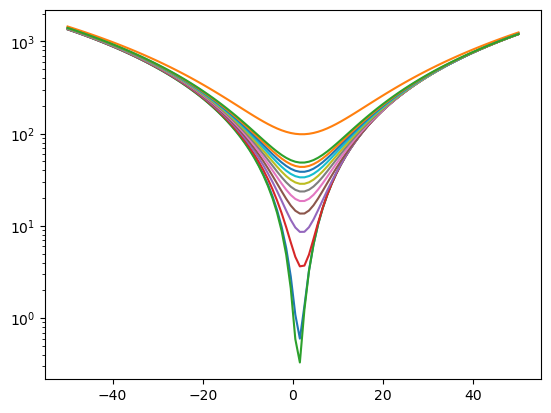

In [36]:
zs = np.linspace(-50,50,100)
moreaus_1 = [moreau_envelope(V,y,z,Delta,1,w) for z in zs]
# continue in steps of 5
moreaus_5 = [moreau_envelope(V,y,z,Delta,5,w) for z in zs]
moreaus_10 = [moreau_envelope(V,y,z,Delta,10,w) for z in zs]
moreaus_15 = [moreau_envelope(V,y,z,Delta,15,w) for z in zs]
moreaus_20 = [moreau_envelope(V,y,z,Delta,20,w) for z in zs]
moreaus_25 = [moreau_envelope(V,y,z,Delta,25,w) for z in zs]
moreaus_30 = [moreau_envelope(V,y,z,Delta,30,w) for z in zs]
moreaus_35 = [moreau_envelope(V,y,z,Delta,35,w) for z in zs]
moreaus_40 = [moreau_envelope(V,y,z,Delta,40,w) for z in zs]
moreaus_45 = [moreau_envelope(V,y,z,Delta,45,w) for z in zs]
moreaus_50 = [moreau_envelope(V,y,z,Delta,50,w) for z in zs]
moreaus_100 = [moreau_envelope(V,y,z,Delta,100,w) for z in zs]
moreaus_0 = [moreau_envelope(V,y,z,Delta,0,w) for z in zs]

import matplotlib.pyplot as plt
# plot with legends
plt.plot(zs, moreaus_1, label='epsilon=1')
plt.plot(zs, moreaus_100, label='epsilon=100')
plt.plot(zs, moreaus_0, label='epsilon=0')
plt.plot(zs, moreaus_5, label='epsilon=5')
plt.plot(zs, moreaus_10, label='epsilon=10')
plt.plot(zs, moreaus_15, label='epsilon=15')
plt.plot(zs, moreaus_20, label='epsilon=20')
plt.plot(zs, moreaus_25, label='epsilon=25')
plt.plot(zs, moreaus_30, label='epsilon=30')
plt.plot(zs, moreaus_35, label='epsilon=35')
plt.plot(zs, moreaus_40, label='epsilon=40')
plt.plot(zs, moreaus_45, label='epsilon=45')
plt.plot(zs, moreaus_50, label='epsilon=50')
plt.yscale('log')
# plt.legend()
plt.show()


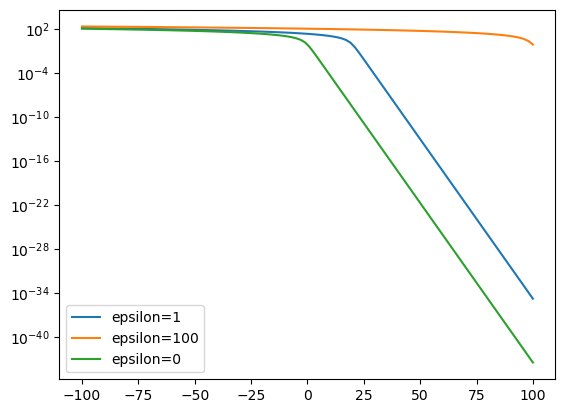

In [17]:
zs = np.linspace(-100,100,100)
loss_20 = [loss(y,z,20,Delta) for z in zs]
loss_100 = [loss(y,z,100,Delta) for z in zs]
loss_0 = [loss(y,z,0,Delta) for z in zs]

# plot with legends
plt.plot(zs, loss_20, label='epsilon=1')
plt.plot(zs, loss_100, label='epsilon=100')
plt.plot(zs, loss_0, label='epsilon=0')
# y log scale
plt.yscale('log')
plt.legend()
plt.show()


So as we can see, indeed the place where the minimum is located converges quickly, but not the value of the minimum. As epsilon to infinity, the value approaches epsilon. We want to know how the value of the minimum changes as a function of epsilon

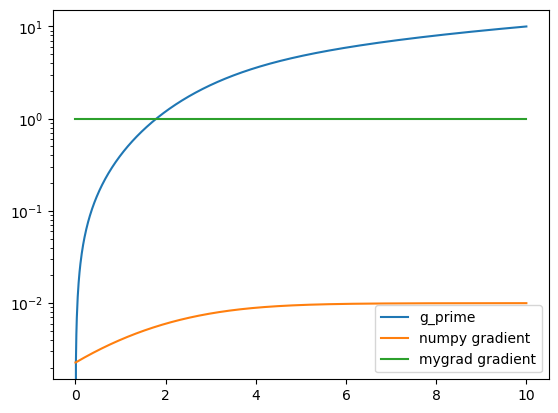

In [55]:
# def my_moreau_gradient(V,y,Deltaepsilon,w):
#     proximal = proximal_logistic_root_scalar(V,y,Delta,epsilon,w)

#     z_star = proximal
#     arg = y*z_star - epsilon * Delta
#     cosh = 2 + 2 *np.cosh(arg)
#     first = y*(w - z_star) / ( cosh)
#     if arg <= 0:
#         second = V / ((1 + np.exp(arg)) * cosh)
#     else:
#         second = V * np.exp(-arg) / ((1 + np.exp(-arg)) * cosh)
#     epsilon_term = (first + second) * epsilon / Delta
#     return epsilon_term

def stable_sigmoid(x):
    # if the argument is no numpy array, make it one
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    out = np.zeros_like(x)
    idx = x <= 0
    out[idx] = np.exp(x[idx]) / (1 + np.exp(x[idx]))
    idx = x > 0
    out[idx] = 1 / (1 + np.exp(-x[idx]))
    return out

def optim_gradient(z,y,V,w_prime):
    a = y*z
    if a <= 0:
        return y*V/(1+ np.exp(y*z)) + w_prime - z
    else:
        return y*V*np.exp(-y*z)/(1+ np.exp(-y*z)) + w_prime - z

def proximal_logistic_root_scalar_gradient(V: float, y: float, Deltaepsilon: float, w:float) -> float:
    if y == 0:
        return w
    try:
        w_prime = w - Deltaepsilon / y
        result = root_scalar(lambda z: optim_gradient(z,y,V,w_prime) , bracket=[-50000000,50000000],xtol=10e-10,rtol=10e-10)
        z = result.root
        return z + Deltaepsilon / y
    except Exception as e:
        # print all parameters
        print("V: ", V, "y: ", y, "Deltaepsilon:", Deltaepsilon, "w: ", w)
        raise e

def g_prime_gradient(V,y,Deltaepsilon,w):
    z_star = proximal_logistic_root_scalar_gradient(V,y,Deltaepsilon,w)    
    arg = y*z_star - Deltaepsilon
    g_prime = stable_sigmoid(-arg)
    g_prime *= Deltaepsilon
    return g_prime

def loss_gradient(y,z,Deltaepsilon):
    return log1pexp(-y*z+Deltaepsilon)

def moreau_envelope_gradient(V,y,z,Deltaepsilon,w):
    return loss_gradient(y,z,Deltaepsilon)  + ((z-w)**2)/(2*V)


def moreau_envelope_for_gradient(V,y,Deltaepsilon,w):
    # if epsilon is a numpy array or a mg tensor do this, otherwise only for one epsilon
    if isinstance(Deltaepsilon, np.ndarray) or isinstance(Deltaepsilon, mg.Tensor):
        zs = np.array([ proximal_logistic_root_scalar_gradient(V,y,e,w) for e in Deltaepsilon])
    else:
        zs = proximal_logistic_root_scalar_gradient(V,y,Deltaepsilon,w)
    return moreau_envelope_gradient(V,y,zs,Deltaepsilon,w)


import mygrad as mg
eps = np.linspace(0,10,1000)
eps_tensor = mg.tensor(eps)
f = moreau_envelope_for_gradient(V,y,eps_tensor,w)
f.backward()
mg_grad = f.grad
g_prime = [g_prime_gradient(V,y,e,w) for e in eps]
values_moreau = np.array([moreau_envelope_for_gradient(V,y,e,w) for e in eps])
numpy_gradient = np.gradient(values_moreau)

# plot with legends
# plt.plot(eps, my_moreau, label='my moreau')
plt.plot(eps, g_prime, label='g_prime')
plt.plot(eps, numpy_gradient, label='numpy gradient')
plt.plot(eps, mg_grad, label='mygrad gradient')

# y log scale
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()